In [75]:
import requests
import json
from concurrent.futures import ThreadPoolExecutor
import time
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys

In [29]:
EXCHANGE_LIST = ['UPBIT', 'BINANCE', 'COINBASE', 'OKX']


In [30]:
def get_price(market: str, exchange: str):
    assert market in ['BTC', 'ETH', 'XRP']
    assert exchange in EXCHANGE_LIST

    if exchange == 'UPBIT':
        res = json.loads(requests.get("https://api.upbit.com/v1/ticker",
                         params={"markets": f'KRW-{market},KRW-USDT'}).text)
        krw_price = res[0]['trade_price']
        usdt_rate = res[1]['trade_price']
        return krw_price/usdt_rate
    elif exchange == 'BINANCE':
        res = json.loads(requests.get(
            "https://api.binance.com/api/v3/ticker/price", params={"symbol": f'{market}USDT'}).text)
        price = res['price']

        return float(price)
    elif exchange == 'COINBASE':
        res = json.loads(requests.get(
            f"https://api.exchange.coinbase.com/products/{market}-USDT/ticker").text)
        price = res['price']

        return float(price)
    elif exchange == 'OKX':
        res = json.loads(requests.get(
            f"https://www.okx.com/api/v5/market/index-tickers?instId={market}-USDT").text)
        price = res['data'][0]['idxPx']

        return float(price)


In [51]:
def get_orderbook(market: str):
    assert market in ['BTC', 'ETH', 'XRP']
    res = json.loads(requests.get("https://api.upbit.com/v1/orderbook?level=0",
                      params={"markets": f'KRW-{market}'}).text)
    return res

In [83]:
recent_prices = []
recent_ratios = []
THRESHOLD = 0.0012
MARKET = 'BTC'
LOADING_COUNT = 60
TIMESTEP = 3
print(f"Loading for {LOADING_COUNT*TIMESTEP} seconds...")
for _ in tqdm(range(LOADING_COUNT)):  # 평균내기 위해 일단 60개 채우기
    with ThreadPoolExecutor(max_workers=10) as pool:
        res = list(pool.map(lambda m: get_price(MARKET, m), EXCHANGE_LIST))

    res = np.array(res)
    ratio_now = res[0] / np.average(res[1:])
    recent_ratios.append(ratio_now)
    recent_prices.append(res)

    time.sleep(TIMESTEP)


recent_prices = np.array(recent_prices)
recent_ratios = np.array(recent_ratios)


orderbooks = []
flag_cnt = 0
cnt = 0 
while True:
    t1 = time.time()
    with ThreadPoolExecutor(max_workers=10) as pool:
        res = list(pool.map(lambda m: get_price(MARKET, m), EXCHANGE_LIST))
    ###

    res = np.array(res)
    ratio_now = res[0] / np.average(res[1:])
    delta = ratio_now - np.average(recent_ratios)

    ####
    buy_flag = 0
    cnt+=1
    if delta < -THRESHOLD:
        buy_flag = 1
        flag_cnt +=1
        print(f'BUY FLAG : {flag_cnt}/{cnt}')

    orderbooks.append({
        "buy_flag": buy_flag,
        "orderbook": get_orderbook(MARKET),
        "ratio": ratio_now,
        'delta': delta
    })

    recent_prices = np.vstack([recent_prices[1:], res])
    recent_ratios = np.append(recent_ratios[1:], ratio_now)

    time.sleep(TIMESTEP)


Loading for 180 seconds...


100%|██████████| 60/60 [03:20<00:00,  3.34s/it]


BUY FLAG : 1/205
BUY FLAG : 2/206
BUY FLAG : 3/209
BUY FLAG : 4/210
BUY FLAG : 5/240
BUY FLAG : 6/241
BUY FLAG : 7/784
BUY FLAG : 8/786
BUY FLAG : 9/787
BUY FLAG : 10/788
BUY FLAG : 11/789
BUY FLAG : 12/790
BUY FLAG : 13/2446
BUY FLAG : 14/2949
BUY FLAG : 15/2950
BUY FLAG : 16/2951
BUY FLAG : 17/2952
BUY FLAG : 18/2953
BUY FLAG : 19/3115
BUY FLAG : 20/3682
BUY FLAG : 21/3683
BUY FLAG : 22/3686
BUY FLAG : 23/3756


KeyboardInterrupt: 

In [84]:
ask_prices = np.array(list(
    map(lambda x: x['orderbook'][0]['orderbook_units'][0]['ask_price'], orderbooks)))
flags = np.where(np.array(list(map(lambda x: x['buy_flag'], orderbooks))) == 1)


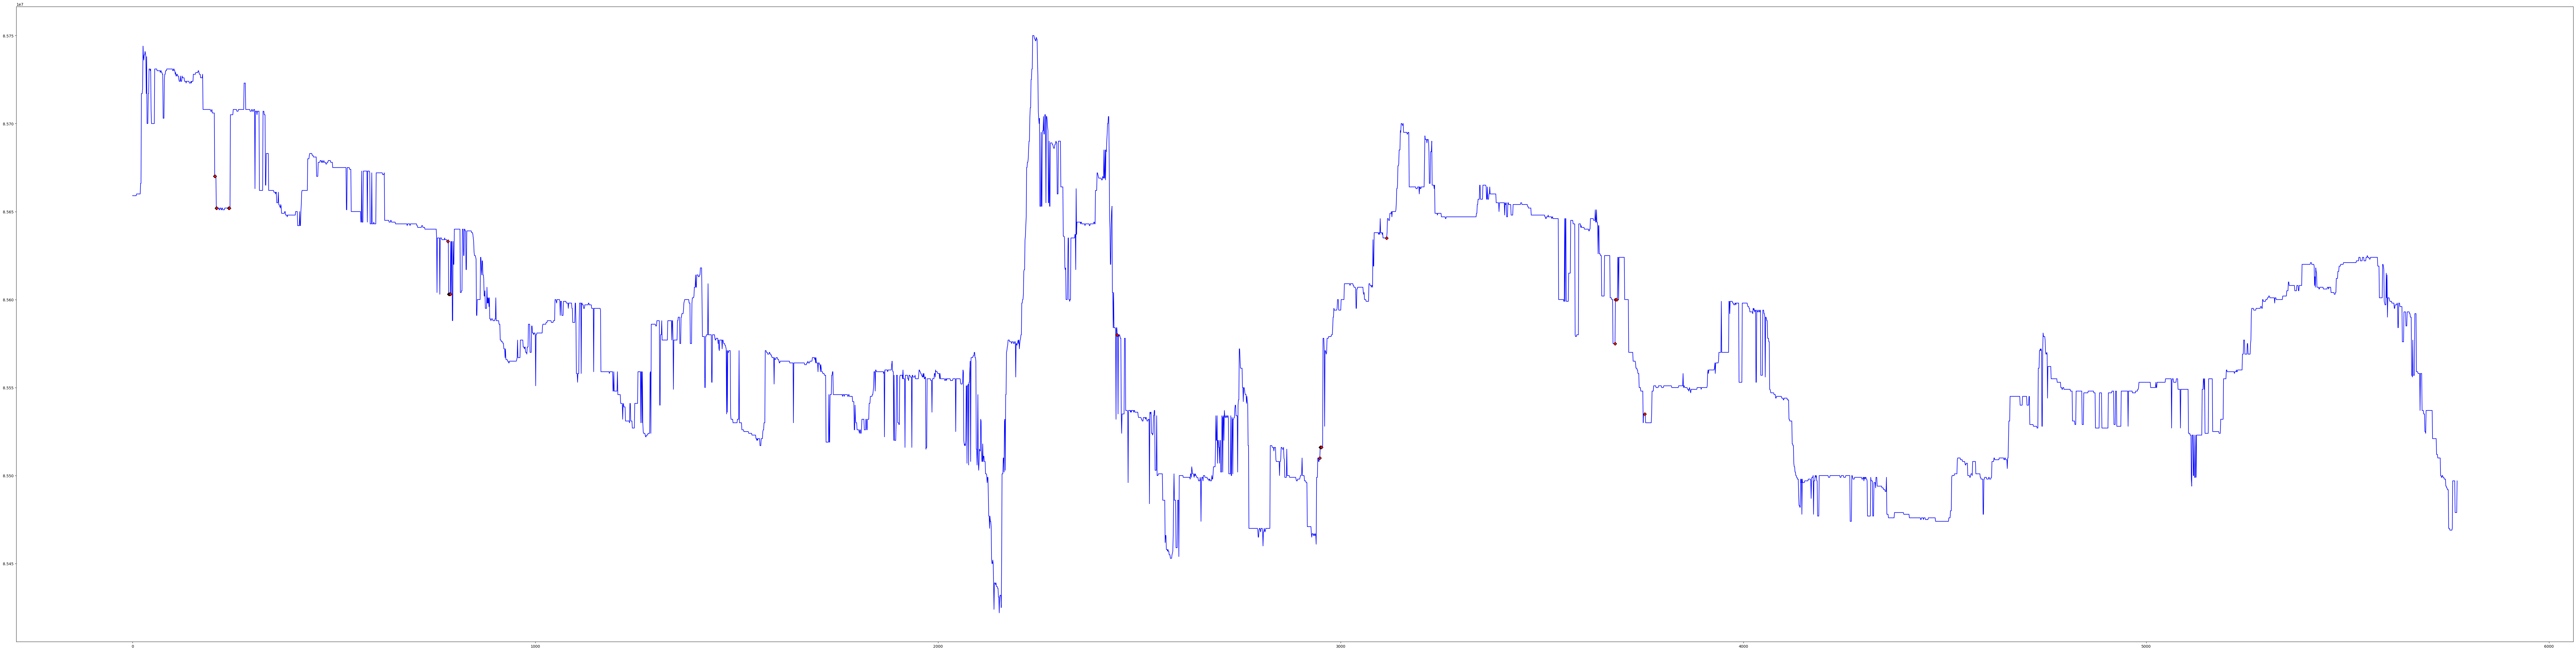

In [85]:
plt.figure(figsize=(120,30))
plt.plot(ask_prices,'-D', markevery=flags[0],c='blue', mfc='red', mec='k')
plt.show()

In [96]:
window = 2000
for i in flags[0]:
    if orderbooks[i]['buy_flag'] == 1:
        ask = orderbooks[i]['orderbook'][0]['orderbook_units'][0]['ask_price']
        max_bid = max([o['orderbook'][0]['orderbook_units'][0]
                      ['bid_price'] for o in orderbooks[i:i+window]])
        delta = orderbooks[i]['delta']
        print(f"{delta:.6f} {i:4d}, {ask:.1f} {'>' if ask>max_bid else '<'} {max_bid:.1f}, {(max_bid - ask)-0.0005*(max_bid+ask): .4f}")
        print(f"가격 상승 퍼센트 : {(max_bid-ask)/ask*100:.3f}%")


-0.001313  204, 85670000.0 < 85708000.0, -47689.0000
가격 상승 퍼센트 : 38000
-0.001285  205, 85670000.0 < 85708000.0, -47689.0000
가격 상승 퍼센트 : 38000
-0.001236  208, 85652000.0 < 85708000.0, -29680.0000
가격 상승 퍼센트 : 56000
-0.001215  209, 85652000.0 < 85708000.0, -29680.0000
가격 상승 퍼센트 : 56000
-0.001335  239, 85652000.0 < 85735000.0, -2693.5000
가격 상승 퍼센트 : 83000
-0.001307  240, 85652000.0 < 85735000.0, -2693.5000
가격 상승 퍼센트 : 83000
-0.001534  783, 85633000.0 < 85748000.0,  29309.5000
가격 상승 퍼센트 : 115000
-0.001474  785, 85603000.0 < 85748000.0,  59324.5000
가격 상승 퍼센트 : 145000
-0.001435  786, 85603000.0 < 85748000.0,  59324.5000
가격 상승 퍼센트 : 145000
-0.001397  787, 85603000.0 < 85748000.0,  59324.5000
가격 상승 퍼센트 : 145000
-0.001358  788, 85603000.0 < 85748000.0,  59324.5000
가격 상승 퍼센트 : 145000
-0.001359  789, 85603000.0 < 85748000.0,  59324.5000
가격 상승 퍼센트 : 145000
-0.001212 2445, 85580000.0 < 85695000.0,  29362.5000
가격 상승 퍼센트 : 115000
-0.001363 2948, 85510000.0 < 85695000.0,  99397.5000
가격 상승 퍼센트 : 185000


In [92]:
85670000 * 0.05 / 100

42835.0